<a href="https://colab.research.google.com/github/doukansurel/Machine-Learning-worksheet/blob/main/CNN_BeginnerProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0# Veri artırma işlemlerini tanımlayın



In [ ]:
test_labels

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


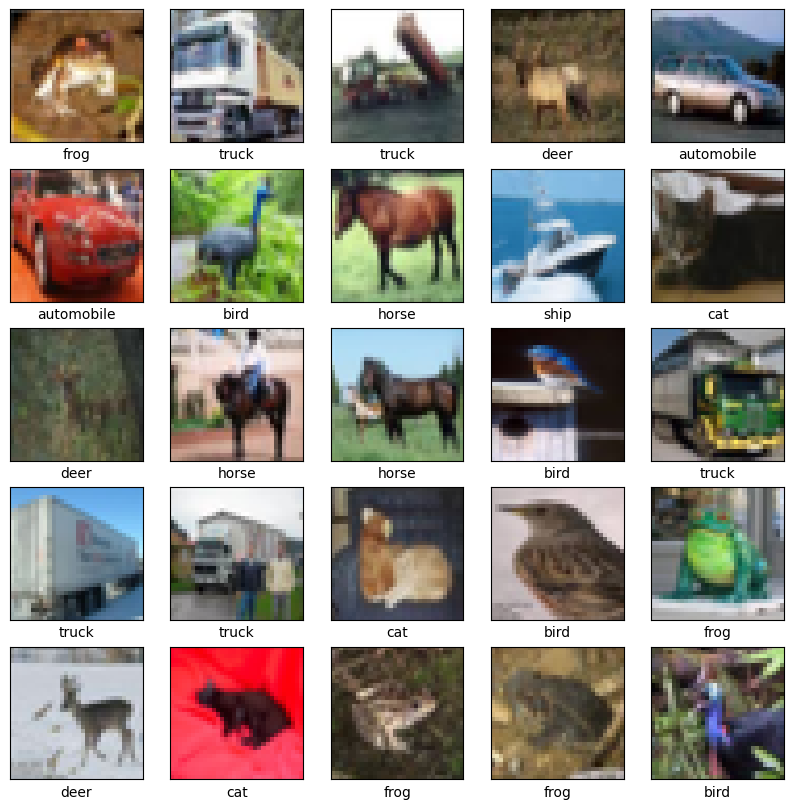

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Let's display the architecture of your model so far:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 6, 6, 128)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)        

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

Here's the complete architecture of your model:

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# model.compile(optimizer = opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels))

Epoch 1/5
1563/1563 [==============================] - 12s 6ms/step - loss: 2.2579 - accuracy: 0.1445 - val_loss: 2.1588 - val_accuracy: 0.2322
Epoch 2/5
1563/1563 [==============================] - 9s 6ms/step - loss: 2.0757 - accuracy: 0.2298 - val_loss: 1.9784 - val_accuracy: 0.2861
Epoch 3/5
 557/1563 [=========>....................] - ETA: 7s - loss: 1.9847 - accuracy: 0.2655

KeyboardInterrupt: ignored

### Evaluate the model

313/313 - 1s - loss: 0.7520 - accuracy: 0.7472 - 799ms/epoch - 3ms/step


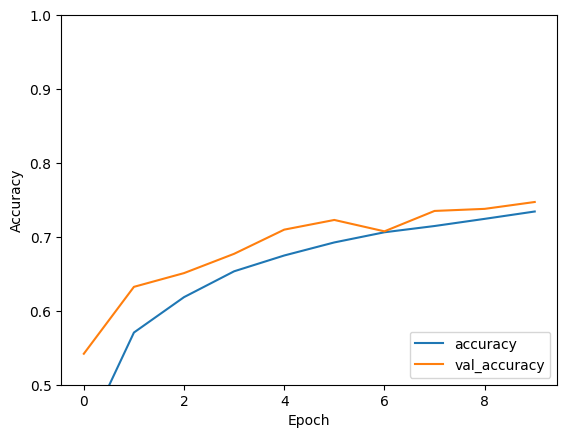

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

0.7773000001907349


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.

In [ ]:
prediction = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [ ]:

# Sınıf etiketleri listesi
class_labels =['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# test_images üzerinde tahmin yapın
predictions = model.predict(test_images)
predicted_labels = [class_labels[np.argmax(pred)] for pred in predictions]  # En yüksek olasılığa sahip sınıfın ismini al

# Model doğruluk değerini hesaplama
accuracy = model.evaluate(test_images, test_labels)[1]

313/313 [==============================] - 1s 3ms/step - loss: 0.7181 - accuracy: 0.7559


In [ ]:
prediction_probabilities = []

for i in predictions:
  print(i)
  prediction_probabilities.append(i[np.argmax(i)])

In [ ]:
prediction_probabilities

In [ ]:
predictions.shape

(10000, 10)

In [ ]:
predictions

array([[2.98559908e-02, 9.37666162e-04, 5.15603321e-03, ...,
        1.30734965e-03, 1.96243785e-02, 6.23479206e-03],
       [2.20031328e-02, 1.60560701e-02, 2.13507174e-05, ...,
        7.93198129e-09, 9.60656464e-01, 1.23709394e-03],
       [1.96672410e-01, 6.79842457e-02, 1.60157792e-02, ...,
        4.26908815e-03, 6.18456304e-01, 5.72347157e-02],
       ...,
       [2.69771146e-04, 2.62006826e-04, 4.86623272e-02, ...,
        1.08778914e-02, 2.57962995e-04, 1.37094845e-04],
       [3.57657485e-03, 9.88167465e-01, 6.20262523e-04, ...,
        1.11212044e-04, 2.58210552e-04, 5.87697979e-03],
       [1.52977245e-05, 3.33567868e-07, 2.05354663e-04, ...,
        8.98027062e-01, 8.72442243e-08, 2.12734403e-06]], dtype=float32)

In [ ]:
np.argmax(predictions[3])

0

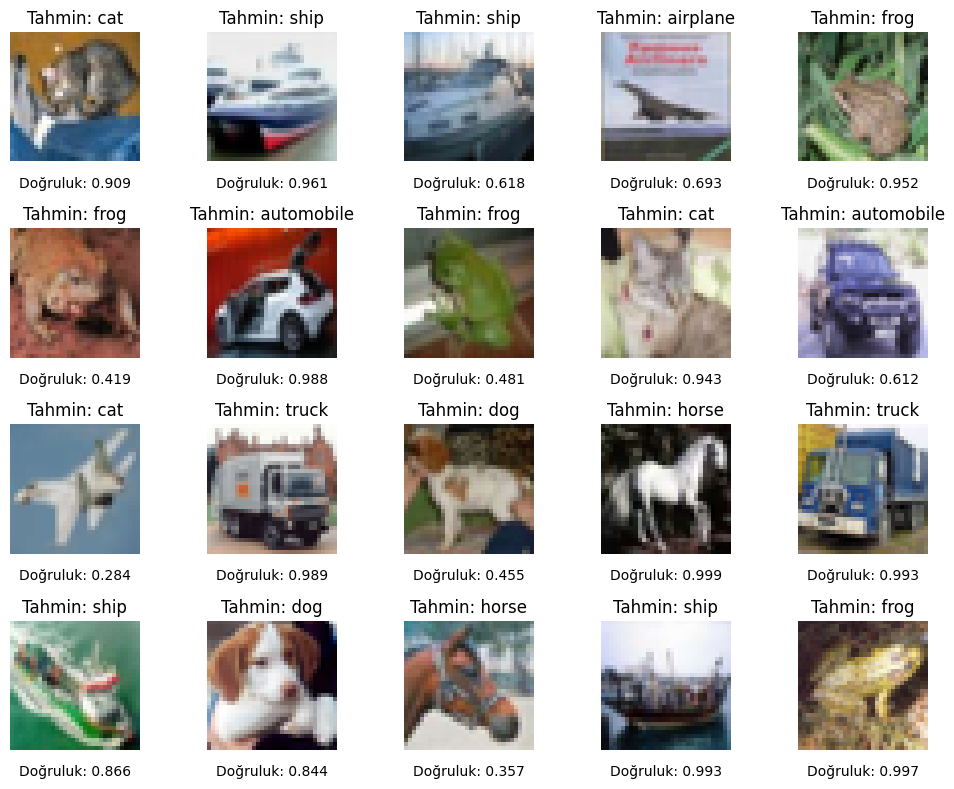

In [ ]:
# Sadece ilk 20 tahmini görüntüleme
num_predictions = 20
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

for i in range(num_predictions):
    ax = axes[i // 5, i % 5]
    ax.imshow(test_images[i], cmap='gray')  # Tahmin etmek istediğimiz görüntülerin olduğu test_images
    ax.set_title(f'Tahmin: {predicted_labels[i]}')  # Tahmin edilen etiketin ismini başlık olarak ayarlama
    ax.axis('off')

    # Tahmin sonucunu ve doğruluk değerini fotoğrafın üstünde gösterme
    ax.text(0.5, -0.2, f'Doğruluk: {prediction_probabilities[i]:.3f}', transform=ax.transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.show()